In [47]:
from langgraph.graph import StateGraph , START , END
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from typing import TypedDict , Literal
from pydantic import BaseModel , Field 
import os

In [48]:
load_dotenv()

api_key = os.getenv("OPENAI_API_KEY")

In [49]:
model = ChatOpenAI(api_key=api_key,model="gpt-4o-mini")

In [50]:
class SentimentSchema(BaseModel):
    sentiment :Literal["positive","negative"] = Field(description="Sentiment of the review")

In [51]:
class DiagnoseState(BaseModel):
    issue_type:Literal["UX","Performance","Bug","Support","Other"] = Field(description="The category of the issue mention in the review")
    tone:Literal["angery","frustration","disappointment","calm"] = Field(description="The emotional feelings expressed by the user")
    urgency:Literal["Low","Medium","High"] = Field(description="How the issue is crytical ?")

In [52]:
structure_model = model.with_structured_output(SentimentSchema)
diagnose_model = model.with_structured_output(DiagnoseState)

In [53]:
class ReviewState(TypedDict):
    review:str
    sentiment:str
    diagnose:dict
    response:str

In [54]:
def find_sentiment(state:ReviewState):
    review = state['review']

    prompt = f"You are the helpfull assistant and you have the expertise to find the sentiment on the following \n{review}"

    sentiment = structure_model.invoke(prompt)
    
    return {"sentiment":sentiment}

In [55]:
def diagnorse_review(state:ReviewState):

    review = state['review']

    prompt = f"You have given a negative review and you have to analyze three major following thing from the \n {review}. \n Following things are \n issue_type , tone and urgency on the review"
    
    diagnose = diagnose_model.invoke(prompt)

    return {"diagnose":diagnose.model_dump()}

In [56]:
def generate_postive_response(state:ReviewState):
    
    review = state['review']
    

    prompt = f"You are the help assistant who have the expertise to generate the positive response based on the following review \n {review}"

    response = model.invoke(prompt)

    return {"response":response}

In [57]:
def generate_negative_response(state:ReviewState):
    
    diagnose = state['diagnose']

    issue_type = diagnose['issue_type']
    tone = diagnose['tone']
    urgency = diagnose['urgency']
    

    prompt = f"""
    You are the help assistant \n 
    who have the expertise to generate the negative 
    response and user had a {issue_type} issue , sounded {tone} and mark urgency {urgency} write a empathic , helpful resolution message on the following diagnose \n {diagnose}"""

    response = model.invoke(prompt)

    return {"response":response}

In [ ]:
def check_sentiment(state: ReviewState) -> Literal["diagnorse_review", "generate_postive_response"]:
    sentiment = state['sentiment'].sentiment
  
    if sentiment == "positive":
        print("Sentiment in Postive")
        return "generate_postive_response"
    print("Sentiment is negative")
    return "diagnorse_review"


In [59]:
# creating graph

graph = StateGraph(ReviewState)

# add nodes

graph.add_node("find_sentiment",find_sentiment)
graph.add_node("diagnorse_review",diagnorse_review)
graph.add_node("generate_postive_response",generate_postive_response)
graph.add_node("generate_negative_response",generate_negative_response)

# add edges

graph.add_edge(START,"find_sentiment")
graph.add_conditional_edges("find_sentiment",check_sentiment)
graph.add_edge("generate_postive_response",END)
graph.add_edge("diagnorse_review","generate_negative_response")
graph.add_edge("generate_negative_response",END)

In [60]:
# Creating workflow 

workflow = graph.compile()

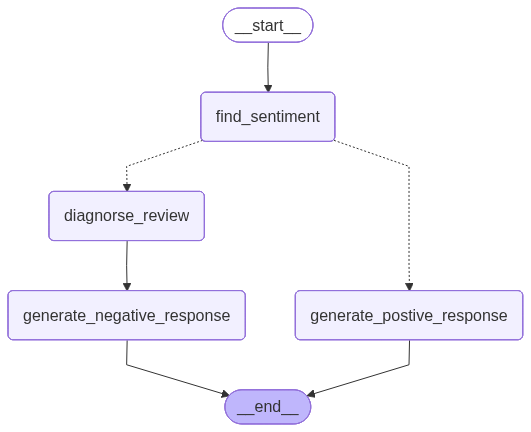

In [61]:
from IPython.display import Image

Image(workflow.get_graph().draw_mermaid_png())

In [62]:
inital_prompt = {"review":"I’m genuinely impressed with the performance of this platform! Pages load almost instantly, and even heavy tasks are handled smoothly without any lag. The optimization is top-notch, which makes the overall experience seamless and efficient. Kudos to the team for putting so much effort into speed and stability — it’s truly a game-changer! 🔥"}

final_result = workflow.invoke(inital_prompt)

print("--sentiment--")

print(final_result['sentiment'])

print("--diagnose--")

print(final_result.get("diagnose",""))

print("--response--")

print(final_result['response'])




positive
Sentiment is negative
--sentiment--
sentiment='positive'
--diagnose--
{'issue_type': 'Performance', 'tone': 'calm', 'urgency': 'Low'}
--response--
content="Subject: We're Here to Help with Your Performance Issue\n\nDear [User's Name],\n\nThank you for reaching out regarding the performance issue you’re experiencing. We understand how frustrating it can be when things aren't functioning as smoothly as expected, and we appreciate your patience as we work together to get this resolved.\n\nTo assist you better, could you please provide a bit more detail about the specific performance issues you’ve been encountering? Any information on when these issues occur or what tasks seem to be affected would be immensely helpful.\n\nIn the meantime, here are a few general steps you might consider trying to improve performance:\n\n1. **Clear Cache:** Sometimes, clearing the cache of your application can help improve responsiveness.\n2. **Close Unused Applications:** Closing down any unnecessa